In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [3]:
batch_size = 64

transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [4]:
def dataloader_to_numpy(dataloader):
    data = []
    labels = []
    for images, targets in dataloader:
        # data.extend(images.numpy().reshape(-1, 28, 28))
        batch_size = images.size(0)
        data.extend(images.view(batch_size, -1).numpy())
        labels.extend(targets.numpy())
    return np.array(data), np.array(labels)

In [5]:
train_data, train_labels = dataloader_to_numpy(trainloader)
test_data, test_labels = dataloader_to_numpy(testloader)

print("Training data shape:", train_data.shape)
print("Training labels shape:", train_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)

Training data shape: (60000, 784)
Training labels shape: (60000,)
Test data shape: (10000, 784)
Test labels shape: (10000,)


In [6]:

class DNN_1Layer:
    def __init__(self, x, y, neuron, learning_rate=0.01) -> None:
        self.bias = self.build_basis_function(x)
        self.labels = np.unique(y)
        self.one_hot_encoded = np.eye(len(self.labels))[y]
        self.weight1 = self.build_weight_init((self.bias.shape[1], neuron))
        self.weight2 = self.build_weight_init((neuron + 1, len(self.labels)))
        self.lr = learning_rate
    
    @staticmethod
    def build_weight_init(shape):
        input_size, output_size = shape
        limit = np.sqrt(6.0 / (input_size + output_size))
        weights = np.random.uniform(-limit, limit, shape)
        return weights
    
    @staticmethod
    def build_basis_function(x):
        return np.hstack((np.ones((x.shape[0], 1)), x))
    
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def softmax(x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    @staticmethod
    def cross_entropy(y_true, y_pred):
        return -np.sum(y_true * np.log(y_pred + 1e-9)) / len(y_true)
    
    @staticmethod
    def accuracy(y_true, y_pred):
        return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))
    
    def forward(self, a0):
        z0 = self.build_basis_function(a0)
        a1 = z0 @ self.weight1
        z1 = self.sigmoid(a1)
        z1 = self.build_basis_function(z1)
        a2 = z1 @ self.weight2
        z2 = self.softmax(a2)
        return z0, a1, z1, a2, z2
    
    def backward(self, z0, a1, z1, a2, z2, y):
        delta_k = z2 - y
        delta_w2 = z1.T @ delta_k
        delta_j = self.sigmoid_backward(a1) * (delta_k @ self.weight2[1:, :].T)
        delta_w1 = z0.T @ delta_j
        return delta_w2, delta_w1
    
    def update(self, delta_w2, delta_w1):
        self.weight1 -= self.lr * delta_w1
        self.weight2 -= self.lr * delta_w2
    
    def sigmoid_backward(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def train(self, X, y, epochs=10, batch_size=32, shuffle=True):
        accuracies = []
        for epoch in range(epochs):
            '''
            if shuffle:
                X, y = self.shuffle_data(X, y)
            '''
            total_loss = 0
            total_acc = 0
            for i in range(0, len(X), batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                z0, a1, z1, a2, z2 = self.forward(X_batch)
                delta_w2, delta_w1 = self.backward(z0, a1, z1, a2, z2, y_batch)
                self.update(delta_w2, delta_w1)
                loss = self.cross_entropy(y_batch, z2)
                acc = self.accuracy(y_batch, z2)
                total_loss += loss * len(X_batch)
                total_acc += acc * len(X_batch)
            total_loss /= len(X)
            total_acc /= len(X)
            print(f'Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f} - Accuracy: {total_acc:.4f}')
            accuracies.append(total_acc)
        return np.mean(accuracies)
    
    def shuffle_data(self, X, y):
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        return X[indices], y[indices]

In [7]:
hidden_size = [5, 10, 20, 50, 75, 100]
train_accuracies = []
test_accuracies = []
for neuron in hidden_size:
    model = DNN_1Layer(train_data, train_labels, neuron=neuron, learning_rate=0.01)
    model.train(train_data, model.one_hot_encoded, epochs=10, batch_size=batch_size)
    
    # Compute training accuracy
    train_output = model.forward(train_data)[-1]
    train_accuracy = model.accuracy(model.one_hot_encoded, train_output)
    train_accuracies.append(train_accuracy)
    
    # Compute testing accuracy
    test_output = model.forward(test_data)[-1]
    test_accuracy = model.accuracy(np.eye(10)[test_labels], test_output)
    test_accuracies.append(test_accuracy)
    

Epoch 1/10 - Loss: 0.7283 - Accuracy: 0.8042
Epoch 2/10 - Loss: 0.4922 - Accuracy: 0.8599
Epoch 3/10 - Loss: 0.4648 - Accuracy: 0.8659
Epoch 4/10 - Loss: 0.4526 - Accuracy: 0.8688
Epoch 5/10 - Loss: 0.4455 - Accuracy: 0.8712
Epoch 6/10 - Loss: 0.4401 - Accuracy: 0.8727
Epoch 7/10 - Loss: 0.4351 - Accuracy: 0.8736
Epoch 8/10 - Loss: 0.4303 - Accuracy: 0.8746
Epoch 9/10 - Loss: 0.4253 - Accuracy: 0.8763
Epoch 10/10 - Loss: 0.4196 - Accuracy: 0.8777
Epoch 1/10 - Loss: 0.5328 - Accuracy: 0.8566
Epoch 2/10 - Loss: 0.3157 - Accuracy: 0.9093
Epoch 3/10 - Loss: 0.2857 - Accuracy: 0.9167
Epoch 4/10 - Loss: 0.2696 - Accuracy: 0.9217
Epoch 5/10 - Loss: 0.2580 - Accuracy: 0.9258
Epoch 6/10 - Loss: 0.2490 - Accuracy: 0.9278
Epoch 7/10 - Loss: 0.2422 - Accuracy: 0.9301
Epoch 8/10 - Loss: 0.2370 - Accuracy: 0.9318
Epoch 9/10 - Loss: 0.2327 - Accuracy: 0.9330
Epoch 10/10 - Loss: 0.2291 - Accuracy: 0.9336
Epoch 1/10 - Loss: 0.4234 - Accuracy: 0.8872
Epoch 2/10 - Loss: 0.2320 - Accuracy: 0.9342
Epoch 3/

KeyboardInterrupt: 

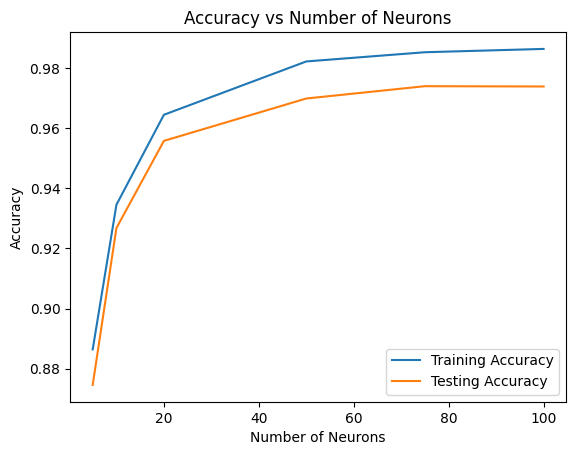

In [ ]:
plt.plot(hidden_size, train_accuracies, label='Training Accuracy')
plt.plot(hidden_size, test_accuracies, label='Testing Accuracy')
plt.xlabel('Number of Neurons')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Neurons')
plt.legend()
plt.show()